## Урок 6. Сегментация

In [1]:
#!pip install git+https://github.com/tensorflow/examples.git

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [29]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Следующий код выполнит простую аугументацию данных посредством переворота изображений. В дополнение изображение будет нормализовано к 0 и 1. Пиксели сегментационной маски будут помечены {1, 2, 3}, но для удобства из данного цифрового ряда будет вычтено по 1 и в итоге получиться {0, 1, 2}

In [30]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [31]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [32]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [33]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [34]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [35]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [36]:
# пример изображения из датасета и соотвествующую ему маску из датасета.
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

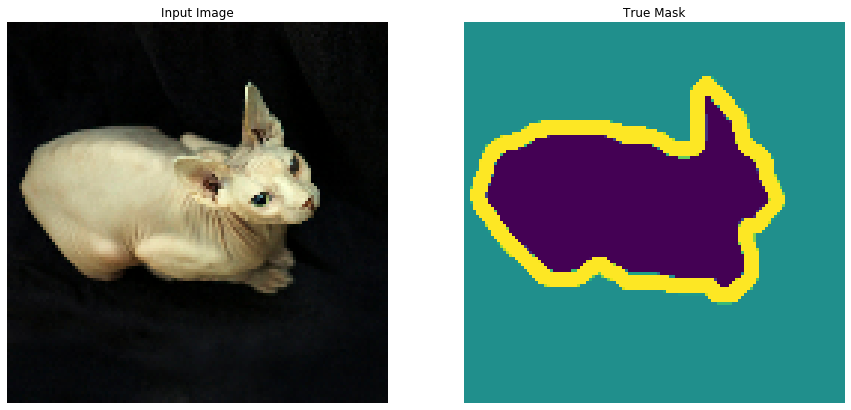

In [11]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2. Декодером будет апсемпл блок уже имплементированный в TensorFlow examples Pix2pix tutorial.
Причина по который будет испольваться три канала заключается в том что у нас 3 возможных лейбла на каждый пиксель. Можно это воспринимать как классиификацию где кажедый пиксель будет принадлежать одному из трех классов (объект, граница, фон)

In [37]:
OUTPUT_CHANNELS = 3

In [13]:
# энкодр не будет участвовать в процессе тренировкие модели.
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [14]:
base_model.get_config()

{'name': 'mobilenetv2_1.00_128',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'ZeroPadding2D',
   'config': {'name': 'Conv1_pad',
    'trainable': False,
    'dtype': 'float32',
    'padding': ((0, 1), (0, 1)),
    'data_format': 'channels_last'},
   'name': 'Conv1_pad',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Conv2D',
   'config': {'name': 'Conv1',
    'trainable': False,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'con

In [38]:
# Декодер/апсемплер это просто серия апсемпл блоков имплементированнхы в TensorFlow examples.
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

все что осталось это скомпилировать модель и начать процесс ее тренировки. Loss-функция, которую будем использовать - losses.SparseCategoricalCrossentropy(from_logits=True). Причина использования данной loss-функции заключается в том, что нейросеть пытается назначить каждому пикселю лейбл, также как в задачах предсказания класса. Для модели в которой 3 каннала каждый из которых пытается предсказать класс losses.SparseCategoricalCrossentropy(from_logits=True) обычно также рекомендуется. На выходе нейросети каждому пикселю назначается лейбл с наибольшим значением. Это то, что делает функция create_mask.

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

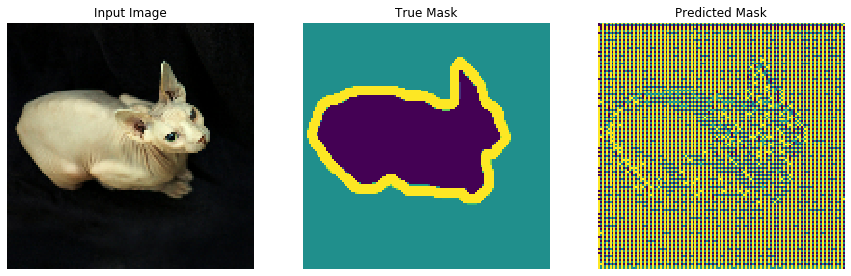

In [20]:
show_predictions()

Давайте осуществлять мониторинг того как улучшается работа модели в процессе обучения. Для завершения этой задачи callback функция определена ниже.

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

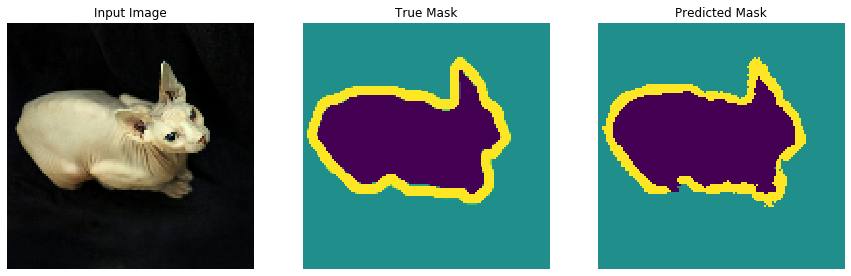


Sample Prediction after epoch 5

57/57 [==============================] - 507s 9s/step - loss: 0.2543 - accuracy: 0.8930 - val_loss: 0.2720 - val_accuracy: 0.8907
CPU times: user 2h 37min 51s, sys: 5min 36s, total: 2h 43min 28s
Wall time: 46min 53s


In [22]:
%%time
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

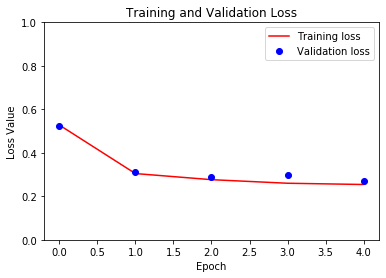

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Давайте сделаем несколько предсказаний. Для экономии времени использовалось небольшое количество эпох, но вы можете его увеличить для того чтобы модель давала более точные результаты.

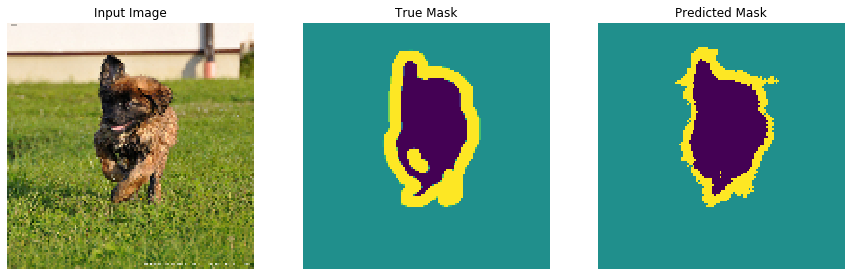

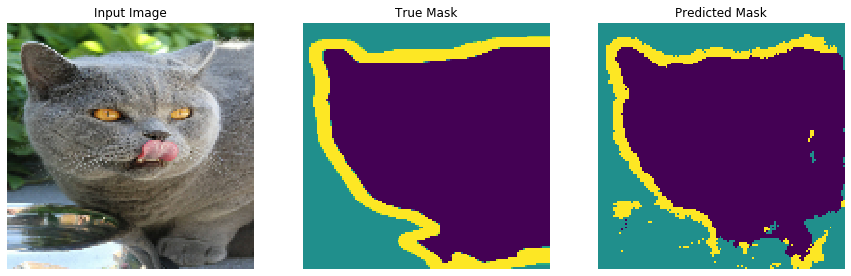

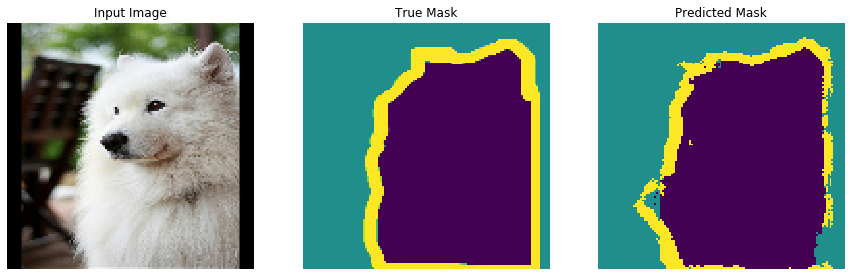

In [24]:
show_predictions(test_dataset, 3)

### Практическое задание

**1. Попробуйте обучить нейронную сеть U-Net либо на другом датасете либо с другим бэкбоном (другой свёрточной частью). Опишите в комментарии к уроку - какой результата вы добились от нейросети?**

In [39]:
# энкодр не будет участвовать в процессе тренировкие модели.
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
                  'conv1_conv',
                  'conv2_block1_1_relu',
                  'conv3_block1_1_relu',
                  'conv4_block2_2_relu',
                  'conv5_block1_2_relu'
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [26]:
base_model.get_config()

{'name': 'resnet50v2',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_3'},
   'name': 'input_3',
   'inbound_nodes': []},
  {'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': False,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'name': 'conv1_pad',
   'inbound_nodes': [[['input_3', 0, 0, {}]]]},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': False,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': 

In [40]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

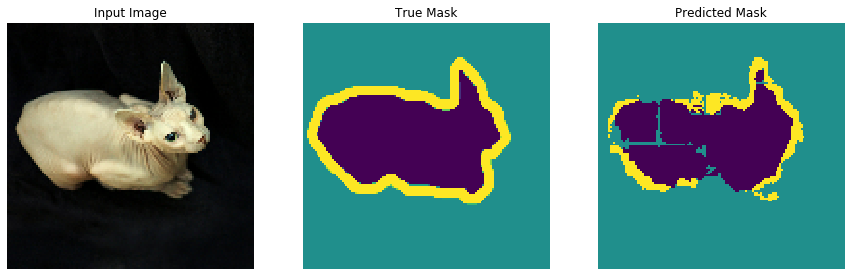


Sample Prediction after epoch 5

57/57 [==============================] - 648s 11s/step - loss: 0.2711 - accuracy: 0.8841 - val_loss: 0.3957 - val_accuracy: 0.8444
CPU times: user 3h 25min 48s, sys: 6min 4s, total: 3h 31min 53s
Wall time: 55min 19s


In [42]:
%%time
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

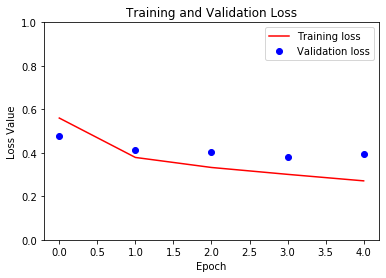

In [43]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

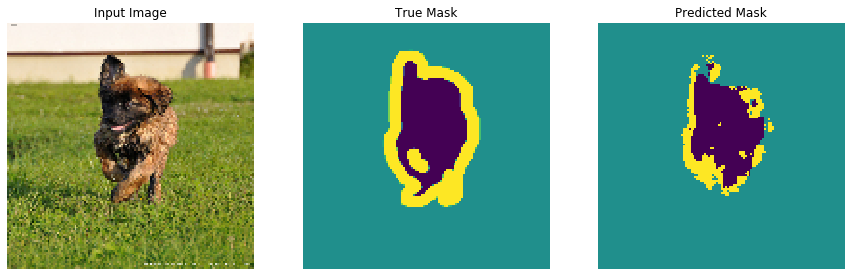

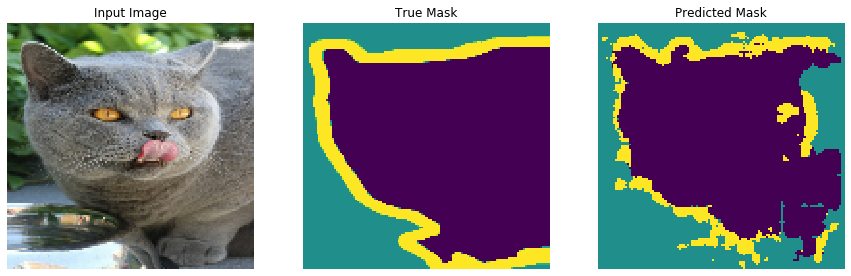

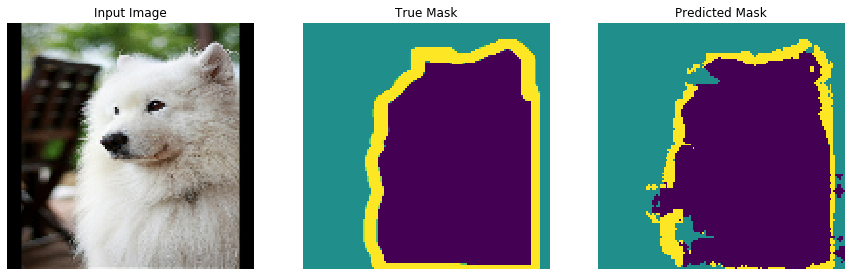

In [44]:
show_predictions(test_dataset, 3)

**Итого:  
получилось заменить бэкбон с MobileNetV2 на ResNet50V2. Правда слои для down_stack пытался подобрать "методом тыка" через base_model.get_config() по аналогии с конфигурацией MobileNetV2. Вероятно поэтому результат оказался хуже - это хорошо видно и по тествым картинкам и по метрикам MobileNetV2:val_loss=0.2730 val_accuracy=0.8889 против ResNet50V2:val_loss=0.3957 val_accuracy=0.8444 (хотя судя по слайду "разновидности cnn" из презентации к 4 уроку ResNet50 способен обойти по качеству MobileNet)**